### **Simplified Implementation of knowledge distillation in LLMs**
This is a minimal single-file script Implementation of knowledge distillation in LLMs. Knowledge distillation uses a large “teacher” model to guide the training of a smaller “student” model so that the student mimics the teacher’s core capabilities but at reduced computational cost. In this implementation, we use GPT-2 124M as student model and GPT-2 Medium 340M as teacher via reverse Kullback-Leibler (KL) divergence. 

**Reference Papers**: https://arxiv.org/abs/1503.02531, https://arxiv.org/abs/2306.08543 

Bsically we minimize the *reverse KL* divergence, proceeding through the following steps:

**(1)** We first define our overall objective:
$$
\theta \;=\;\arg\min_{\theta} L(\theta).
$$
Here, $\theta$ are the parameters of the student model, and $L(\theta)$ is the loss we aim to minimize.

**(2)** We then instantiate $L(\theta)$ as the reverse KL divergence between the student distribution $q_{\theta}$ and the teacher distribution $p$:
$$
\theta \;=\;\arg\min_{\theta}\;\mathrm{KL}\bigl[q_{\theta} \,\|\, p\bigr].
$$
This focuses training on matching the teacher’s high-probability outputs, avoiding the overemphasis on rare modes induced by forward KL.

**(3)** Finally, we expand the reverse KL objective for text generation:
$$
\theta \;=\;\arg\min_{\theta}
\Bigl[\,-\,\mathbb{E}_{\,x \sim p_x,\;y\sim q_{\theta}}\;\log\!\biggl(\frac{p(y\mid x)}{\,q_{\theta}(y \mid x)}\biggr)\Bigr].
$$
In practice, this leads to a *mode-seeking* behavior, aligning the student’s most likely outputs with those of the teacher while assigning lower probability to unlikely sequences.

<img src="assets/meth.png" />


Loading teacher and student models...
Loading a small subset of OpenWebText dataset...
Tokenizing dataset...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Streaming output truncated to the last 5000 lines.
step 17/5000, loss: 1.1983
step 18/5000, loss: 1.0328
step 19/5000, loss: 1.2989
step 20/5000, loss: 1.3451
step 21/5000, loss: 1.2157
step 22/5000, loss: 1.1031
step 23/5000, loss: 1.0572
step 24/5000, loss: 0.9709
step 25/5000, loss: 1.5088
step 26/5000, loss: 1.1439
step 27/5000, loss: 0.8624
step 28/5000, loss: 1.4996
step 29/5000, loss: 2.0317
step 30/5000, loss: 0.9370
step 31/5000, loss: 1.0354
step 32/5000, loss: 1.3377
step 33/5000, loss: 0.9648
step 34/5000, loss: 1.2608
step 35/5000, loss: 1.3695
step 36/5000, loss: 1.0112
step 37/5000, loss: 1.0084
step 38/5000, loss: 1.0430
step 39/5000, loss: 2.9537
step 40/5000, loss: 1.0600
step 41/5000, loss: 1.1919
step 42/5000, loss: 1.5256
step 43/5000, loss: 1.0082
step 44/5000, loss: 1.2172
step 45/5000, loss: 1.0341
step 46/5000, loss: 1.0750
step 47/5000, loss: 1.3476
step 48/5000, loss: 3.5077
step 49/5000, loss: 1.2183
step 50/5000, loss: 0.9547
step 51/5000, loss: 1.0068
step

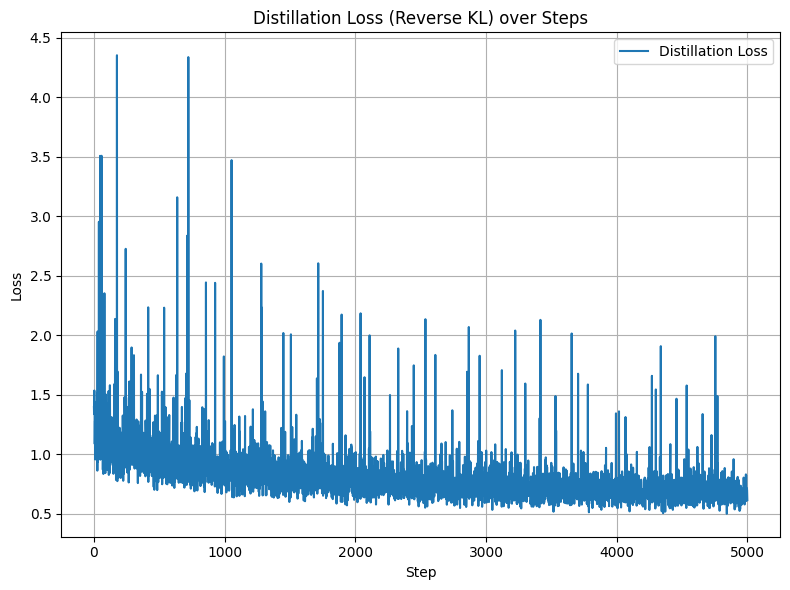

In [13]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datasets import load_dataset

from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)

# -----------------------------
# Hyperparameters
# -----------------------------
MODEL_NAME_TEACHER = "gpt2-medium"  # ~345M params
MODEL_NAME_STUDENT = "gpt2"         # ~124M params
BATCH_SIZE = 2                      # For GPU-poor environments; increase if possible
MAX_STEPS = 5000                    # Number of training steps
WARMUP_STEPS = 20
LR = 5e-5                           # Reduced learning rate for stability
TEMPERATURE = 2.0                   # Temperature for softening distributions
MAX_SEQ_LEN = 128                   # Sequence length
LOG_EVERY = 1                       # Print loss every X steps
GRAD_CLIP = 1.0                     # Gradient clipping norm
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------
# Load Teacher & Student Models + Tokenizer
# -----------------------------------------------------
print("Loading teacher and student models...")
teacher_model = GPT2LMHeadModel.from_pretrained(MODEL_NAME_TEACHER).to(DEVICE)
teacher_model.eval()  # Teacher is fixed/frozen

student_model = GPT2LMHeadModel.from_pretrained(MODEL_NAME_STUDENT).to(DEVICE)
student_model.train()  # We'll train the student

tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME_STUDENT)
# GPT-2 does not have a pad token by default; set pad_token to EOS
tokenizer.pad_token = tokenizer.eos_token

# -----------------------------------------------------
# Load a Small Chunk of OpenWebText
# -----------------------------------------------------
print("Loading a small subset of OpenWebText dataset...")
owt = load_dataset("openwebtext", split="train[:1%]")  # ~a few thousand samples
owt = owt.select(range(min(len(owt), 1000)))          # Subset (e.g., 1000 samples)

# -----------------------------------------------------
# Preprocess / Tokenize
# -----------------------------------------------------
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_SEQ_LEN,
        padding="max_length",
    )

print("Tokenizing dataset...")
owt_tokenized = owt.map(tokenize_function, batched=True, num_proc=1)
owt_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Split into train/eval
train_size = int(0.9 * len(owt_tokenized))
train_dataset = owt_tokenized.select(range(train_size))
eval_dataset = owt_tokenized.select(range(train_size, len(owt_tokenized)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# -----------------------------------------------------
# Define the Distillation Loss (Reverse KL)
# -----------------------------------------------------
def distillation_loss(student_logits, teacher_logits, attention_mask, temperature=TEMPERATURE):
    """
    Distillation loss based on KL(Teacher || Student).
    We apply temperature scaling to soften the distributions.
    """
    # Scale logits by temperature
    s_logits = student_logits / temperature
    t_logits = teacher_logits / temperature

    # Compute log probabilities for student and probabilities for teacher
    s_log_probs = F.log_softmax(s_logits, dim=-1)   # (B, L, V)
    t_probs = F.softmax(t_logits, dim=-1)          # (B, L, V)

    # Compute KL divergence (Teacher || Student) per token
    kl_div = F.kl_div(
        s_log_probs,
        t_probs,
        reduction="none",  # Keep per-element losses
        log_target=False
    )  # (B, L, V)

    kl_per_token = kl_div.sum(-1)  # Sum over vocabulary: (B, L)

    # Apply attention mask to ignore padding tokens
    mask = attention_mask.float()   # (B, L)

    # Compute average loss over all non-padded tokens
    loss = (kl_per_token * mask).sum() / mask.sum()

    # Scale the loss by temperature squared as per standard KD practice
    loss = loss * (temperature ** 2)

    return loss

# -----------------------------------------------------
# Optimizer & Scheduler
# -----------------------------------------------------
optimizer = AdamW(student_model.parameters(), lr=LR)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=MAX_STEPS,
)

# -----------------------------------------------------
# Train
# -----------------------------------------------------
print("Starting knowledge distillation training...")
global_step = 0
losses = []
train_iter = iter(train_loader)

while global_step < MAX_STEPS:
    try:
        batch = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        batch = next(train_iter)

    input_ids = batch["input_ids"].to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE)

    # Forward teacher (no gradient)
    with torch.no_grad():
        teacher_outputs = teacher_model(input_ids, attention_mask=attention_mask)
        teacher_logits = teacher_outputs.logits  # (B, L, V)

    # Forward student
    student_outputs = student_model(input_ids, attention_mask=attention_mask)
    student_logits = student_outputs.logits      # (B, L, V)

    # Compute distillation loss (Reverse KL)
    loss = distillation_loss(
        student_logits=student_logits,
        teacher_logits=teacher_logits,
        attention_mask=attention_mask,
        temperature=TEMPERATURE,
    )

    # Backprop and update
    optimizer.zero_grad()
    loss.backward()

    # Gradient Clipping
    torch.nn.utils.clip_grad_norm_(student_model.parameters(), GRAD_CLIP)

    optimizer.step()
    scheduler.step()

    # Record loss and step
    losses.append(loss.item())
    global_step += 1

    # Logging
    if global_step % LOG_EVERY == 0:
        print(f"step {global_step}/{MAX_STEPS}, loss: {loss.item():.4f}")

print("Finished training!")
plt.figure(figsize=(8,6))
plt.plot(losses, label="Distillation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Distillation Loss (Reverse KL) over Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("distillation_loss.png")
print("Saved plot to distillation_loss.png")

# -----------------------------------------------------
# Save Trained Student Model
# -----------------------------------------------------
output_dir = "./distilled-student-gpt2"
student_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Saved distilled student model to {output_dir}")

# -----------------------------------------------------
# Sample from the Distilled Student Model
# -----------------------------------------------------
def generate(prompt, max_length=50, temperature=1.0, top_k=50, top_p=0.95):
    """
    Generate text from the distilled GPT-2 student model.
    Pass attention_mask to avoid warnings and set pad_token_id = eos_token_id.
    """
    student_model.eval()
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=MAX_SEQ_LEN)
    input_ids = inputs["input_ids"].to(DEVICE)
    attention_mask = inputs["attention_mask"].to(DEVICE)

    with torch.no_grad():
        output_ids = student_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,  # to avoid warnings
        )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

sample_prompts = [
    "The curious scientist decided to test a new hypothesis:",
    "Once upon a time in a land far, far away,",
    "In a shocking turn of events today,"
]

print("\n-- Sample Generations from Distilled Student --")
for prompt in sample_prompts:
    output = generate(prompt)
    print(f"Prompt: {prompt}\nCompletion: {output}\n")
